In [1]:
from load_mnist import *
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
np.random.seed(42)
#np.seterr(divide='ignore', invalid='ignore')

In [2]:
X_train, Y_train, X_test, Y_test = load_mnist()

in label loop
in label loop
in label loop
in label loop
in label loop
in label loop
in label loop
in label loop
in label loop
in label loop
in second loop
in second loop
in second loop
in second loop
in second loop
in second loop
in second loop
in second loop
in second loop
in second loop


In [ ]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def ReLU(x):
    return x.clip(0.0)

def softmax(x):
    epsilon = 1e-12
    exp_x = np.exp(x - np.max(x))
    return exp_x / np.sum(exp_x+epsilon, axis=1, keepdims=True)

In [ ]:
def initialize(K, D, D_i, D_o):
    """
    Function initialization matrices / lists with weights and biases with He initialization
    Parameters
        K: # hidden layers
        D: hidden layer #neurons
        D_i: input dimension. 784 for MNIST
        D_o: output dimension. 10 for MNIST
    Returns
        all_weights: weight matrix
        all_biases: bias matrix
    """
    # python Lists holding layers
    all_weights = [None] * (K+1)
    all_biases = [None] * (K+1)

    if K == 0:
        all_weights[0] = np.random.normal(scale = np.sqrt(2/D_i), size=(D_o, D_i))
    else:
        all_weights[0] = np.random.normal(scale = np.sqrt(2/D_i), size=(D, D_i))
        all_weights[-1] = np.random.normal(scale = np.sqrt(2/D), size=(D_o, D))
        all_biases[0] = np.random.normal(scale = np.sqrt(2), size =(D,1))

    all_biases[-1]= np.random.normal(scale = np.sqrt(2), size =(D_o,1))

    # create intermediate layers
    for layer in range(1,K):
        all_weights[layer] = np.random.normal(scale = np.sqrt(2/D), size=(D,D))
        all_biases[layer] = np.random.normal(scale = np.sqrt(2), size=(D,1))

    return all_weights, all_biases

In [533]:
def forward_pass(net_input, all_weights, all_biases):
    """
    Compute forward pass of the weights.
    Parameters
        net_input: image of digit
        all_weights: weight matrices of the network
        all_biases: bias matrix
    
    Returns
        net_output: output from the system, number 0-9
        all_f: stored pre activations
        all_h: stored activations
    """

    K = len(all_weights) -1
    all_f = [None] * (K+1) # pre activations
    all_h = [None] * (K+1) # activations : after non-linear function s.a ReLU

    all_h[0] = net_input

    for layer in range(K):
        all_f[layer] = all_biases[layer].T + all_h[layer] @ all_weights[layer].T
        all_h[layer+1] = ReLU(all_f[layer])

    all_f[K] = all_biases[K].T + all_h[K] @ all_weights[K].T

    net_output = all_f[K] 
    
    return net_output, all_f, all_h

In [553]:
def compute_cost(net_output, y):
    """
    Compute the cross-entropy loss of the output, using the model input and the true output. 
    Parameters
        net_output: model output (with shape: (batch_size, classes). e.g (64, 10))
        y: true output (as given in the load_mnist function. shape: (batch_size, classes))
    Returns
        cost: total cost over all the data points given 
    """
    N_datapoints = np.shape(net_output)[0] # for normalization
    maxval = np.max(net_output, axis=1, keepdims=True) #maximum value of each class: (batchsize, classes) -> (batchsize, 1)

    s = np.log(np.sum(np.exp(net_output - maxval), axis=1, keepdims=True)) - np.sum(y*(net_output-maxval), axis=1, keepdims=True)
    cost = np.mean(s)
    return cost


def d_cost_d_output(net_output, y):
    """
    Computes derivative of cost with respect to the output.
    Parameters
        net_output: last layer of neural network / model output
        y: true label
    Returns
        Vector of derivative of loss with respect to output
    """
    N_datapoints = np.shape(net_output)[0]
    maxval = np.max(net_output, axis=1, keepdims=True)
    return softmax(net_output - maxval) - y # for normalization


In [ ]:
def indicator_function(x):
    x_in = np.array(x)
    x_in[x_in>0] = 1
    x_in[x_in<=0] = 0
    return x_in

def backward_pass(all_weights, all_biases, all_f, all_h, y):
    all_dl_dweights = [None] * (K+1)
    all_dl_dbiases = [None] * (K+1)

    all_dl_df = [None] * (K+1)
    all_dl_dh = [None] * (K+1)

    all_dl_df[K] = np.array(d_cost_d_output(all_f[K], y))

    for layer in range(K, -1, -1):

        all_dl_dbiases[layer] = np.sum(all_dl_df[layer].T, axis=1, keepdims=True) # måste summera över datapunkts dimensionen

        all_dl_dweights[layer] = all_h[layer].T @ all_dl_df[layer] 

        all_dl_dh[layer] = all_dl_df[layer] @ all_weights[layer]

        if layer > 0:
            all_dl_df[layer-1] = indicator_function(all_f[layer-1]) * all_dl_dh[layer]
    
    return all_dl_dweights, all_dl_dbiases

In [ ]:
def update_parameters(weights, biases, dl_dweights, dl_dbias, alpha):

    layers = len(weights) # iterate through the layers

    for layer in range(layers):
        weights[layer] = weights[layer] - alpha * dl_dweights[layer].T
        biases[layer] = biases[layer] - alpha * dl_dbias[layer]
    return weights, biases
    

In [401]:
def random_mini_batches(X_train, Y_train, batch_size):
    """
    Divide the given dataset to batches.
    Parameters:
        X_train: dataset
        Y_train: corresponding labels to the dataset
    
    Returns
        mini_batches: zipped mini-batches x_mini and y_mini
    """

    num_samples = X_train.shape[0]

    indices = np.random.permutation(num_samples)
    X_train_shuffled = X_train[indices]
    Y_train_shuffled = Y_train[indices]

    mini_batches = []
    for i in range(0, num_samples, batch_size):
        end_idx = min(i + batch_size, num_samples)
        mini_batch_X = X_train_shuffled[i:end_idx]
        mini_batch_Y = Y_train_shuffled[i:end_idx]
        mini_batches.append((mini_batch_X, mini_batch_Y))

    return mini_batches


In [567]:
def sp(inp, msg):
    """
    Very useful function for debugging. Prints shapes of arrays.
    """
    print(f"{np.shape(inp)}", " ", msg)

In [ ]:
def train_model(X_train, Y_train, model, iterations, learning_rate, batch_size, X_test, Y_test):
    """
    Trains the model and returns it, i.e a set of weights and biases.
    Parameters
        X_train: all the data
        Y_train: all labels
        model: description of desired model; [int: hidden layers, int: hidden layer neurons, int: input dim (784), output dim (10)]
        iterations: the amount of iterations the weights are updated
        learning_rate: learning rate for the step update
        batch_size: batch size for the stochastic gradient descent
    
    Returns
        all_weights: matrix containing all weights from all layers
        all_biases: same as above but for biases
        cost_list: a list containing the costs for each iteration
        train_accuracy: list containing train accuricies for every eval_k'th iteration
        test_accuracy: same as above for testing data
        iteration_list: iteration indexes for accuracy lists
    """
    eval_k = 20 # How often the model should be evaluated
    K, D, D_i, D_o = model 


    mini_batches = random_mini_batches(X_train, Y_train, batch_size)
    mini_batches_testing = random_mini_batches(X_test, Y_test, batch_size)
    all_weights, all_biases = initialize(K, D, D_i, D_o)
    num_batches = len(X_train) // batch_size
    num_batches_test = len(X_test) // batch_size

    train_cost_list = []
    test_cost_list = []

    train_accuracy = []
    test_accuracy = []

    iteration_list = []

    

    for i in range(iterations): # iterations?
        net_input, y = mini_batches[i%num_batches] # ensure that we don't run out of batches

        # Training
        net_output, all_f, all_h = forward_pass(net_input, all_weights, all_biases)
        all_dl_dweights, all_dl_dbiases = backward_pass(all_weights, all_biases, all_f, all_h, y)
        all_weights, all_biases = update_parameters(all_weights, all_biases, all_dl_dweights, all_dl_dbiases, learning_rate)

        # Evaluation ever eval_k'th iteration

        if i % eval_k == 0:
            net_input_test, y_test_batch = mini_batches_testing[i % num_batches_test]
            train_accuracy.append(performance(all_weights, all_biases, X_train, Y_train))
            test_accuracy.append(performance(all_weights, all_biases, X_test, Y_test))
            iteration_list.append(i)
            test_cost_list.append(compute_cost(forward_pass(net_input_test, all_weights, all_biases)[0], y_test_batch))
            train_cost_list.append(compute_cost(net_output, y))

            print("Iteration: ", i, " of ", iterations)

    return all_weights, all_biases, train_cost_list, test_cost_list, train_accuracy, test_accuracy, iteration_list
    


In [ ]:
def predict(x, weights, bias):
    """
    Predict given an input image x.
    Parameters
        x: an image (resized to 1x784)
        weights: the weights of a model
        bias: the bias of a model
    Returns
        Result (as integer)
        Result (one hot encoded)
    """

    net_output, *_ = forward_pass(x, weights, bias)
    prediction = softmax(net_output)

    res = np.argmax(prediction)
    res_1he = np.zeros((1, 10)) #one hot encoded result

    res_1he[0][res] = 1


    return res, res_1he


In [ ]:
def performance(all_weights, all_biases, X_data, Y_data):
    """
    Checks performance of a model. Uses a random subset of the testing data provided.
    Parameters
        all_weights: weights of model
        all_biases: biases of a model
        X_data: either training or testing data inputs
        Y_data: corresponding labels 
    Returns
        Float between 0 and 1 representing the accuracy score on provided data set
    """

    N = len(X_data)
    N_est = 1000
    correct = 0
    
    # Take a random subset from the whole testing dataset
    indices = np.random.permutation(N)
    X_data_shuffled = X_data[indices]
    Y_data_shuffled = Y_data[indices]

    for i in range(N_est):
        img = X_data_shuffled[i].reshape(1, -1)
        y_true = Y_data_shuffled[i].reshape(1, -1)
        y_pred = predict(img, all_weights, all_biases)

        if y_pred[0] == np.argmax(y_true):
            correct += 1
    
    accuracy = correct / N_est
    return accuracy


In [ ]:
## Linear network in assignment
K = 0
D = 100
D_i = 784
D_o = 10
iterations = 1000
learning_rate = 0.001
batch_size = 100

## Multi-layer network
# K = 2
# D = 100
# D_i = 784
# D_o = 10
# iterations = 1000
# learning_rate = 0.002
# batch_size = 100

model = [K, D, D_i, D_o]

# Insert all'at into the train_model function:
all_weights, all_biases, train_cost_list, test_cost_list, train_accuracy, test_accuracy, iteration_list = train_model(X_train, Y_train, model, iterations, learning_rate, batch_size, X_test, Y_test)

Now entering compute cost for x_test and y_test
Iteration:  0  of  1000
Now entering compute cost for x_test and y_test
Iteration:  20  of  1000
Now entering compute cost for x_test and y_test
Iteration:  40  of  1000
Now entering compute cost for x_test and y_test
Iteration:  60  of  1000
Now entering compute cost for x_test and y_test
Iteration:  80  of  1000
Now entering compute cost for x_test and y_test
Iteration:  100  of  1000
Now entering compute cost for x_test and y_test
Iteration:  120  of  1000
Now entering compute cost for x_test and y_test
Iteration:  140  of  1000
Now entering compute cost for x_test and y_test
Iteration:  160  of  1000
Now entering compute cost for x_test and y_test
Iteration:  180  of  1000
Now entering compute cost for x_test and y_test
Iteration:  200  of  1000
Now entering compute cost for x_test and y_test
Iteration:  220  of  1000
Now entering compute cost for x_test and y_test
Iteration:  240  of  1000
Now entering compute cost for x_test and y_t

Text(0.5, 1.0, 'Cost')

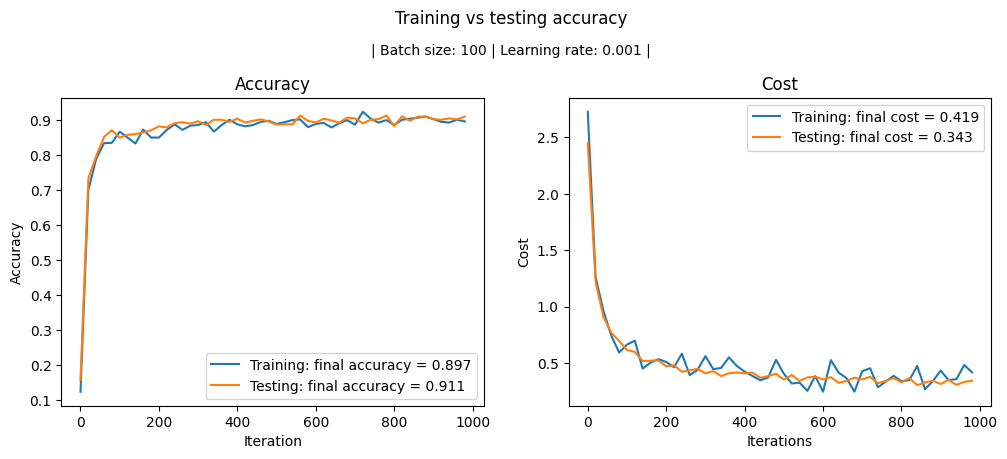

In [565]:

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

sub = f'| Batch size: {batch_size} | Learning rate: {learning_rate} |'
fig.text(0.5, 0.99, sub, ha='center', fontsize=10)

fig.suptitle("Training vs testing accuracy", y=1.1)

axs[0].plot(iteration_list, train_accuracy, label=f"Training: final accuracy = {round(train_accuracy[-1], 3)}")
axs[0].plot(iteration_list, test_accuracy, label=f"Testing: final accuracy = {round(test_accuracy[-1], 3)}")
axs[0].legend()
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Accuracy")
axs[0].set_title("Accuracy")

axs[1].plot(iteration_list, train_cost_list, label=f"Training: final cost = {round(train_cost_list[-1], 3)}")
axs[1].plot(iteration_list, test_cost_list, label=f"Testing: final cost = {round(test_cost_list[-1], 3)}")
axs[1].legend()
axs[1].set_xlabel("Iterations")
axs[1].set_ylabel("Cost")
axs[1].set_title("Cost")

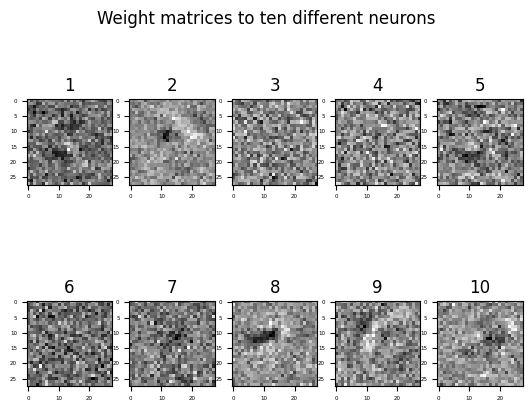

In [ ]:
"""
Extract 10 images
"""
np.shape(all_weights[0][0:10])

imgs = all_weights[0][0:10]

imgs = [i.reshape((28, 28)) for i in imgs]


plt.suptitle("Weight matrices to ten different neurons")

for i in range(1, len(imgs)+1):
    plt.subplot(2, 5, i)
    plt.title(f"{i}")
    plt.imshow(imgs[i-1], cmap="gray")
    plt.tick_params(labelsize=4)
